# Exploratory Data Analysis: ESCO Datasets

This notebook performs a comprehensive exploratory data analysis on the European Skills, Competences, Qualifications and Occupations (ESCO) datasets.

## Datasets Overview
The ESCO taxonomy includes:
- **Skills**: Detailed information about skills and competences
- **Skill Groups**: Hierarchical grouping of skills
- **Skills Hierarchy**: Parent-child relationships between skills
- **Skill-Skill Relations**: Relationships between different skills
- **Occupations**: Detailed information about occupations
- **Occupation-Skill Relations**: Skills required for each occupation
- **Research Collections**: Specialized collections for research purposes


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import networkx as nx

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define data directory
DATA_DIR = Path('../data/esco_datasets/')
print(f"Data directory: {DATA_DIR.absolute()}")


Data directory: /Users/egesualp/Documents/lmu_repos/skills4cpp/notebooks/../data/esco_datasets


## 1. Load All Datasets


In [5]:
# Load core datasets
skills = pd.read_csv(DATA_DIR / 'skills_en.csv')
occ_skills = pd.read_csv(DATA_DIR / 'occupationSkillRelations_en.csv')
skill_hierarchy = pd.read_csv(DATA_DIR / 'skillsHierarchy_en.csv')
skill_groups = pd.read_csv(DATA_DIR / 'skillGroups_en.csv')
occupations = pd.read_csv(DATA_DIR / 'occupations_en.csv')
skill_skill_relations = pd.read_csv(DATA_DIR / 'skillSkillRelations_en.csv')

# Load broader relations if exists
try:
    broader = pd.read_csv(DATA_DIR / 'broaderRelationsSkillPillar_en.csv')
    print("Broader relations loaded successfully")
except FileNotFoundError:
    print("Note: broaderRelationsSkillPillar_en.csv not found, will derive from hierarchy")
    broader = None

print(f"✓ Loaded {len(skills):,} skills")
print(f"✓ Loaded {len(occupations):,} occupations")
print(f"✓ Loaded {len(occ_skills):,} occupation-skill relations")
print(f"✓ Loaded {len(skill_groups):,} skill groups")
print(f"✓ Loaded {len(skill_hierarchy):,} hierarchy entries")
print(f"✓ Loaded {len(skill_skill_relations):,} skill-skill relations")


Broader relations loaded successfully
✓ Loaded 13,939 skills
✓ Loaded 3,039 occupations
✓ Loaded 129,004 occupation-skill relations
✓ Loaded 640 skill groups
✓ Loaded 640 hierarchy entries
✓ Loaded 5,818 skill-skill relations


## 2. Build Skill Taxonomy


In [6]:
# Build the skill taxonomy by joining hierarchy, groups, and skills
print("Building skill taxonomy tree...")

# First, let's understand the structure
print(f"\nSkill hierarchy columns: {list(skill_hierarchy.columns)}")
print(f"Skill groups columns: {list(skill_groups.columns)}")

# The hierarchy appears to use Level structure rather than narrower/broader
# Let's build taxonomy based on available columns
skill_taxonomy = skill_hierarchy.copy()

print(f"\nSkill taxonomy created with {len(skill_taxonomy)} records")
print(f"Columns: {list(skill_taxonomy.columns)}")
display(skill_taxonomy.head())


Building skill taxonomy tree...

Skill hierarchy columns: ['Level 0 URI', 'Level 0 preferred term', 'Level 1 URI', 'Level 1 preferred term', 'Level 2 URI', 'Level 2 preferred term', 'Level 3 URI', 'Level 3 preferred term', 'Description', 'Scope note', 'Level 0 code', 'Level 1 code', 'Level 2 code', 'Level 3 code']
Skill groups columns: ['conceptType', 'conceptUri', 'preferredLabel', 'altLabels', 'hiddenLabels', 'status', 'modifiedDate', 'scopeNote', 'inScheme', 'description', 'code']

Skill taxonomy created with 640 records
Columns: ['Level 0 URI', 'Level 0 preferred term', 'Level 1 URI', 'Level 1 preferred term', 'Level 2 URI', 'Level 2 preferred term', 'Level 3 URI', 'Level 3 preferred term', 'Description', 'Scope note', 'Level 0 code', 'Level 1 code', 'Level 2 code', 'Level 3 code']


,Level 0 URI,Level 0 preferred term,Level 1 URI,Level 1 preferred term,Level 2 URI,Level 2 preferred term,Level 3 URI,Level 3 preferred term,Description,Scope note,Level 0 code,Level 1 code,Level 2 code,Level 3 code
0,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,NaN,NaN,NaN
1,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,http://data.europa.eu/esco/skill/43f425aa-f45d...,languages,NaN,NaN,NaN,NaN,"Ability to communicate through reading, writin...",NaN,L,L1,NaN,NaN
2,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,http://data.europa.eu/esco/skill/e434e71a-f068...,classical languages,NaN,NaN,NaN,NaN,"All dead languages, no longer actively used, o...",Excludes:\n- all languages that are actively ...,L,L2,NaN,NaN
3,http://data.europa.eu/esco/skill/335228d2-297d...,skills,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN
4,http://data.europa.eu/esco/skill/335228d2-297d...,skills,http://data.europa.eu/esco/skill/03e0b95b-67d1...,handling and moving,NaN,NaN,NaN,NaN,"Sorting, arranging, moving, transforming, fabr...",Excludes:\n- Specific skills involving interac...,S,S6,NaN,NaN


## 3. Core Statistics: Skills and Occupations


In [7]:
print("CORE STATISTICS")
print("=" * 80)

# 1. Total counts
total_skills = len(skills)
total_occupations = len(occupations)
total_relations = len(occ_skills)

print(f"\n1. TOTAL COUNTS")
print(f"   • Total Skills: {total_skills:,}")
print(f"   • Total Occupations: {total_occupations:,}")
print(f"   • Total Occupation-Skill Relations: {total_relations:,}")

# 2. Average skills per occupation
avg_skills_per_occ = occ_skills.groupby('occupationUri')['skillUri'].count().mean()
median_skills_per_occ = occ_skills.groupby('occupationUri')['skillUri'].count().median()

print(f"\n2. SKILLS PER OCCUPATION")
print(f"   • Average: {avg_skills_per_occ:.2f} skills/occupation")
print(f"   • Median: {median_skills_per_occ:.0f} skills/occupation")
print(f"   • Min: {occ_skills.groupby('occupationUri')['skillUri'].count().min()}")
print(f"   • Max: {occ_skills.groupby('occupationUri')['skillUri'].count().max()}")


CORE STATISTICS

1. TOTAL COUNTS
   • Total Skills: 13,939
   • Total Occupations: 3,039
   • Total Occupation-Skill Relations: 129,004

2. SKILLS PER OCCUPATION
   • Average: 42.45 skills/occupation
   • Median: 37 skills/occupation
   • Min: 7
   • Max: 345


In [8]:
# 3. Skill Hierarchy Depth and Categories
print("=" * 80)
print("\n3. SKILL HIERARCHY ANALYSIS")

# Count hierarchy levels
level_cols = [col for col in skill_taxonomy.columns if 'Level' in col and 'URI' in col]
print(f"\n   • Number of hierarchy levels: {len(level_cols)}")

# Count non-null entries at each level
for col in sorted(level_cols):
    level_name = col.replace(' URI', '')
    non_null = skill_taxonomy[col].notna().sum()
    print(f"   • {level_name}: {non_null} entries")

# Skill groups analysis
print(f"\n   • Total Skill Groups: {len(skill_groups)}")

# Check if we have pillar information
if 'Level 0 preferred term' in skill_taxonomy.columns:
    pillars = skill_taxonomy['Level 0 preferred term'].value_counts()
    print(f"\n   • Main Pillars ({len(pillars)}):")
    for pillar, count in pillars.items():
        if pd.notna(pillar):
            print(f"     - {pillar}: {count} entries")



3. SKILL HIERARCHY ANALYSIS

   • Number of hierarchy levels: 4
   • Level 0: 640 entries
   • Level 1: 636 entries
   • Level 2: 608 entries
   • Level 3: 452 entries

   • Total Skill Groups: 640

   • Main Pillars (4):
     - skills: 385 entries
     - knowledge: 221 entries
     - transversal skills and competences: 31 entries
     - language skills and knowledge: 3 entries


## 4. Most Frequent Skills and Pillars


MOST FREQUENT SKILLS AND PILLARS

Top 15 Most Frequent Skills (across 3039 occupations):
--------------------------------------------------------------------------------


,Skill,Type,Occurrences,% of Occupations
0,create solutions to problems,skill/competence,347,11.4%
1,use different communication channels,skill/competence,342,11.3%
2,manage staff,skill/competence,338,11.1%
3,manage budgets,skill/competence,324,10.7%
4,keep records of work progress,skill/competence,323,10.6%
5,have computer literacy,skill/competence,319,10.5%
6,quality standards,knowledge,316,10.4%
7,troubleshoot,skill/competence,306,10.1%
8,speak different languages,skill/competence,286,9.4%
9,identify customer's needs,skill/competence,266,8.8%


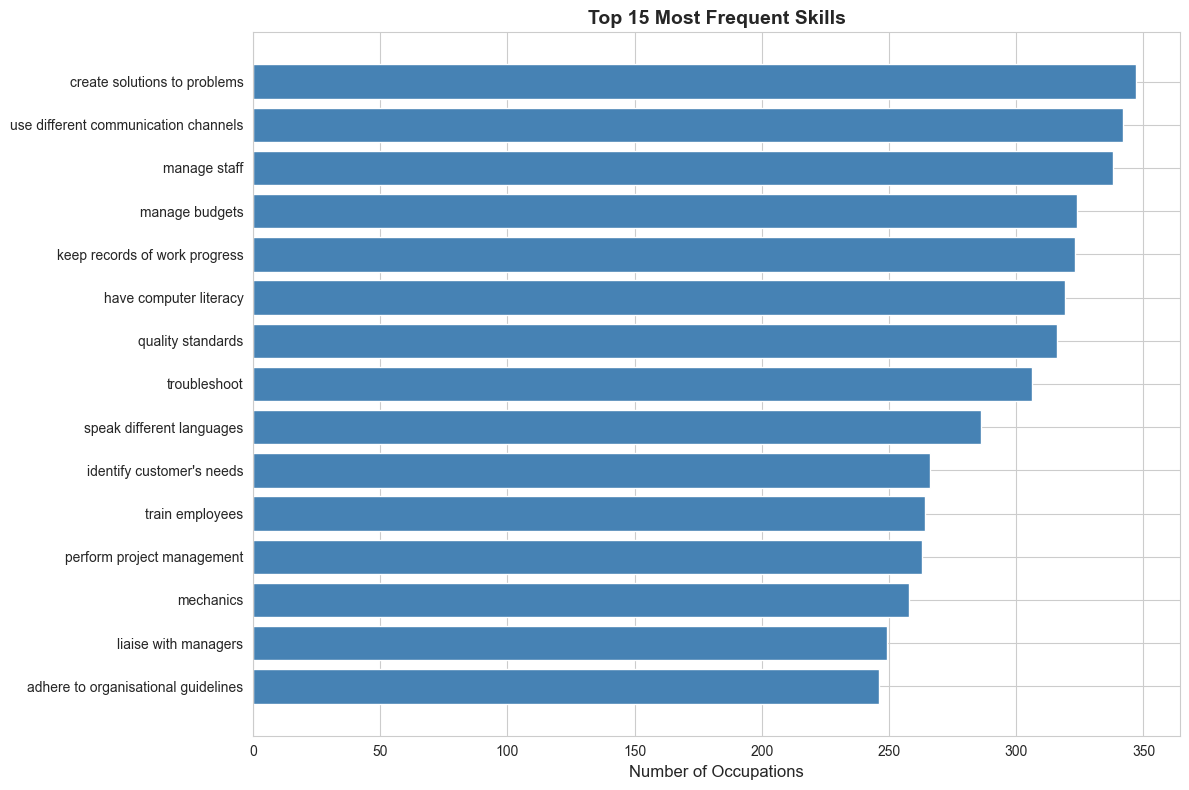

In [9]:
print("MOST FREQUENT SKILLS AND PILLARS")
print("=" * 80)

# Most frequent skills across occupations
skill_frequency = occ_skills.groupby('skillUri').size().sort_values(ascending=False)

print(f"\nTop 15 Most Frequent Skills (across {total_occupations} occupations):")
print("-" * 80)

# Get skill names
top_skills = skill_frequency.head(15)
skill_details = []
for skill_uri, count in top_skills.items():
    skill_info = skills[skills['conceptUri'] == skill_uri]
    if not skill_info.empty:
        skill_name = skill_info.iloc[0]['preferredLabel']
        skill_type = skill_info.iloc[0].get('skillType', 'N/A')
        pct = (count / total_occupations) * 100
        skill_details.append({
            'Skill': skill_name,
            'Type': skill_type,
            'Occurrences': count,
            '% of Occupations': f'{pct:.1f}%'
        })

top_skills_df = pd.DataFrame(skill_details)
display(top_skills_df)

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_skills_df)), top_skills_df['Occurrences'], color='steelblue')
plt.yticks(range(len(top_skills_df)), top_skills_df['Skill'], fontsize=10)
plt.xlabel('Number of Occupations', fontsize=12)
plt.title('Top 15 Most Frequent Skills', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [46]:
skill_taxonomy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Level 0 URI             640 non-null    object
 1   Level 0 preferred term  640 non-null    object
 2   Level 1 URI             636 non-null    object
 3   Level 1 preferred term  636 non-null    object
 4   Level 2 URI             608 non-null    object
 5   Level 2 preferred term  608 non-null    object
 6   Level 3 URI             452 non-null    object
 7   Level 3 preferred term  452 non-null    object
 8   Description             507 non-null    object
 9   Scope note              324 non-null    object
 10  Level 0 code            640 non-null    object
 11  Level 1 code            636 non-null    object
 12  Level 2 code            608 non-null    object
 13  Level 3 code            452 non-null    object
dtypes: object(14)
memory usage: 70.1+ KB


In [48]:
# find top 1 skill in the taxonomy
skill_taxonomy.iloc[:,1].unique()

array(['language skills and knowledge', 'skills',
       'transversal skills and competences', 'knowledge'], dtype=object)

In [49]:
skill_taxonomy.iloc[:,3].unique()

array([nan, 'languages', 'classical languages', 'handling and moving',
       'information skills', 'working with computers', 'constructing',
       'management skills',
       'working with machinery and specialised equipment',
       'assisting and caring',
       'communication, collaboration and creativity',
       'self-management skills and competences',
       'physical and manual skills and competences',
       'life skills and competences',
       'social and communication skills and competences',
       'thinking skills and competences', 'core skills and competences',
       'generic programmes and qualifications', 'education',
       'arts and humanities',
       'social sciences, journalism and information',
       'business, administration and law',
       'natural sciences, mathematics and statistics',
       'information and communication technologies (icts)',
       'engineering, manufacturing and construction',
       'agriculture, forestry, fisheries and veterinary',


In [56]:
"manage staff" in skill_taxonomy.iloc[:,5].unique()

False

In [59]:
skill_taxonomy.iloc[:,7].unique()

array([nan, 'disposing of non-hazardous waste or debris',
       'handling and disposing of hazardous materials',
       'handling and disposing of waste and hazardous materials',
       'positioning materials, tools or equipment', 'moving and lifting',
       'loading and unloading goods and, materials',
       'moving or lifting materials, equipment, or supplies',
       'storing goods and materials', 'making patterns and templates',
       'making production moulds and casts',
       'making moulds, casts, models and patterns', 'making models',
       'tending plants and crops',
       'planting, pruning and harvesting trees, crops and other plants',
       'cultivating land and crops',
       'preparing industrial materials for processing or use',
       'preparing mixtures or solutions',
       'transforming and blending materials',
       'collecting and preparing specimens or materials for testing',
       'washing and maintaining textiles and clothing', 'cleaning',
       'clea

## 5. Pillar Distribution Analysis


PILLAR DISTRIBUTION

Distribution across 4 main pillars:
--------------------------------------------------------------------------------


,Pillar,Skills Count,Percentage
0,skills,385,60.16
1,knowledge,221,34.53
2,transversal skills and competences,31,4.84
3,language skills and knowledge,3,0.47


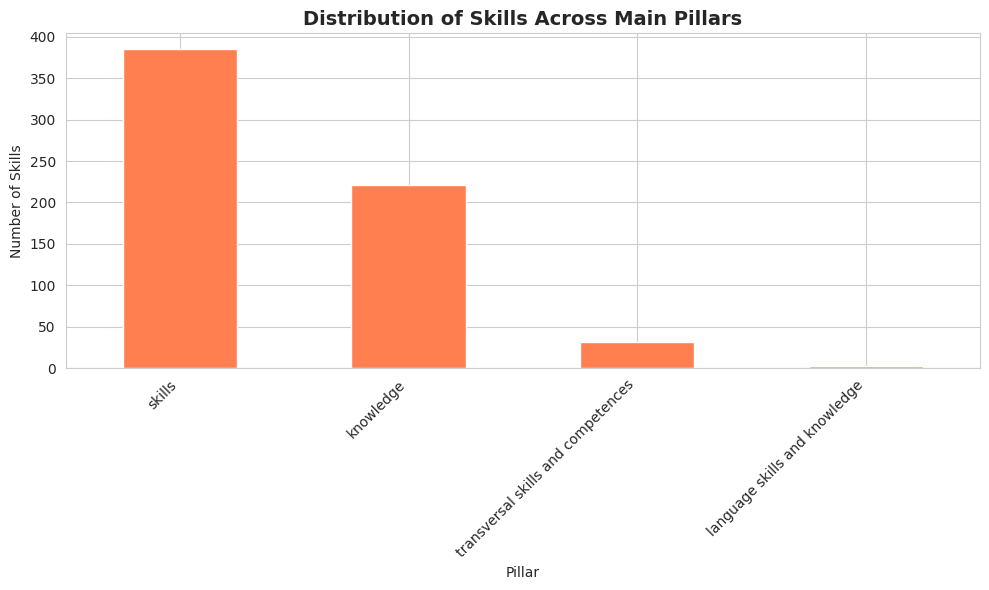

In [ ]:
print("PILLAR DISTRIBUTION")
print("=" * 80)

# Analyze pillars (Level 0)
if 'Level 0 preferred term' in skill_taxonomy.columns:
    pillar_counts = skill_taxonomy['Level 0 preferred term'].value_counts()
    
    print(f"\nDistribution across {len(pillar_counts)} main pillars:")
    print("-" * 80)
    
    pillar_df = pd.DataFrame({
        'Pillar': pillar_counts.index,
        'Skills Count': pillar_counts.values,
        'Percentage': (pillar_counts.values / len(skill_taxonomy) * 100).round(2)
    })
    display(pillar_df)
    
    # Visualize pillar distribution
    plt.figure(figsize=(10, 6))
    pillar_counts.plot(kind='bar', color='coral')
    plt.title('Distribution of Skills Across Main Pillars', fontsize=14, fontweight='bold')
    plt.xlabel('Pillar')
    plt.ylabel('Number of Skills')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nPillar information not directly available in hierarchy")


## 6. Skill Co-occurrence Network Analysis


In [ ]:
print("SKILL CO-OCCURRENCE GRAPH")
print("=" * 80)

# Build co-occurrence graph from skill-skill relations
print(f"\nBuilding skill co-occurrence network from {len(skill_skill_relations)} relations...")

# Create directed graph
G = nx.DiGraph()

# Add edges from skill-skill relations
for _, row in skill_skill_relations.iterrows():
    source = row['originalSkillUri']
    target = row['relatedSkillUri']
    rel_type = row['relationType']
    
    # Add edge with relationship type as attribute
    G.add_edge(source, target, relation_type=rel_type)

print(f"\n   • Total nodes (skills): {G.number_of_nodes()}")
print(f"   • Total edges (connections): {G.number_of_edges()}")
print(f"   • Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Analyze relation types
relation_types = skill_skill_relations['relationType'].value_counts()
print(f"\n   • Relation type distribution:")
for rel_type, count in relation_types.items():
    print(f"     - {rel_type}: {count} ({count/len(skill_skill_relations)*100:.1f}%)")

# Find most connected skills
degree_dict = dict(G.degree())
top_connected = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"\n   • Top 10 Most Connected Skills:")
for skill_uri, degree in top_connected:
    skill_info = skills[skills['conceptUri'] == skill_uri]
    if not skill_info.empty:
        skill_name = skill_info.iloc[0]['preferredLabel']
        print(f"     - {skill_name}: {degree} connections")


SKILL CO-OCCURRENCE GRAPH

Building skill co-occurrence network from 5818 relations...

   • Total nodes (skills): 5650
   • Total edges (connections): 5818
   • Average degree: 2.06

   • Relation type distribution:
     - optional: 5629 (96.8%)
     - essential: 189 (3.2%)

   • Top 10 Most Connected Skills:
     - musical instruments: 25 connections
     - risk management: 22 connections
     - identify support mechanisms to develop your professional practice: 20 connections
     - match needs of target community with your skills: 19 connections
     - accounting: 18 connections
     - nutrition: 17 connections
     - logistics: 17 connections
     - animal welfare legislation: 17 connections
     - variety of tobacco leaves: 16 connections
     - electronics: 16 connections



Visualizing skill co-occurrence network (top 30 most connected skills)...


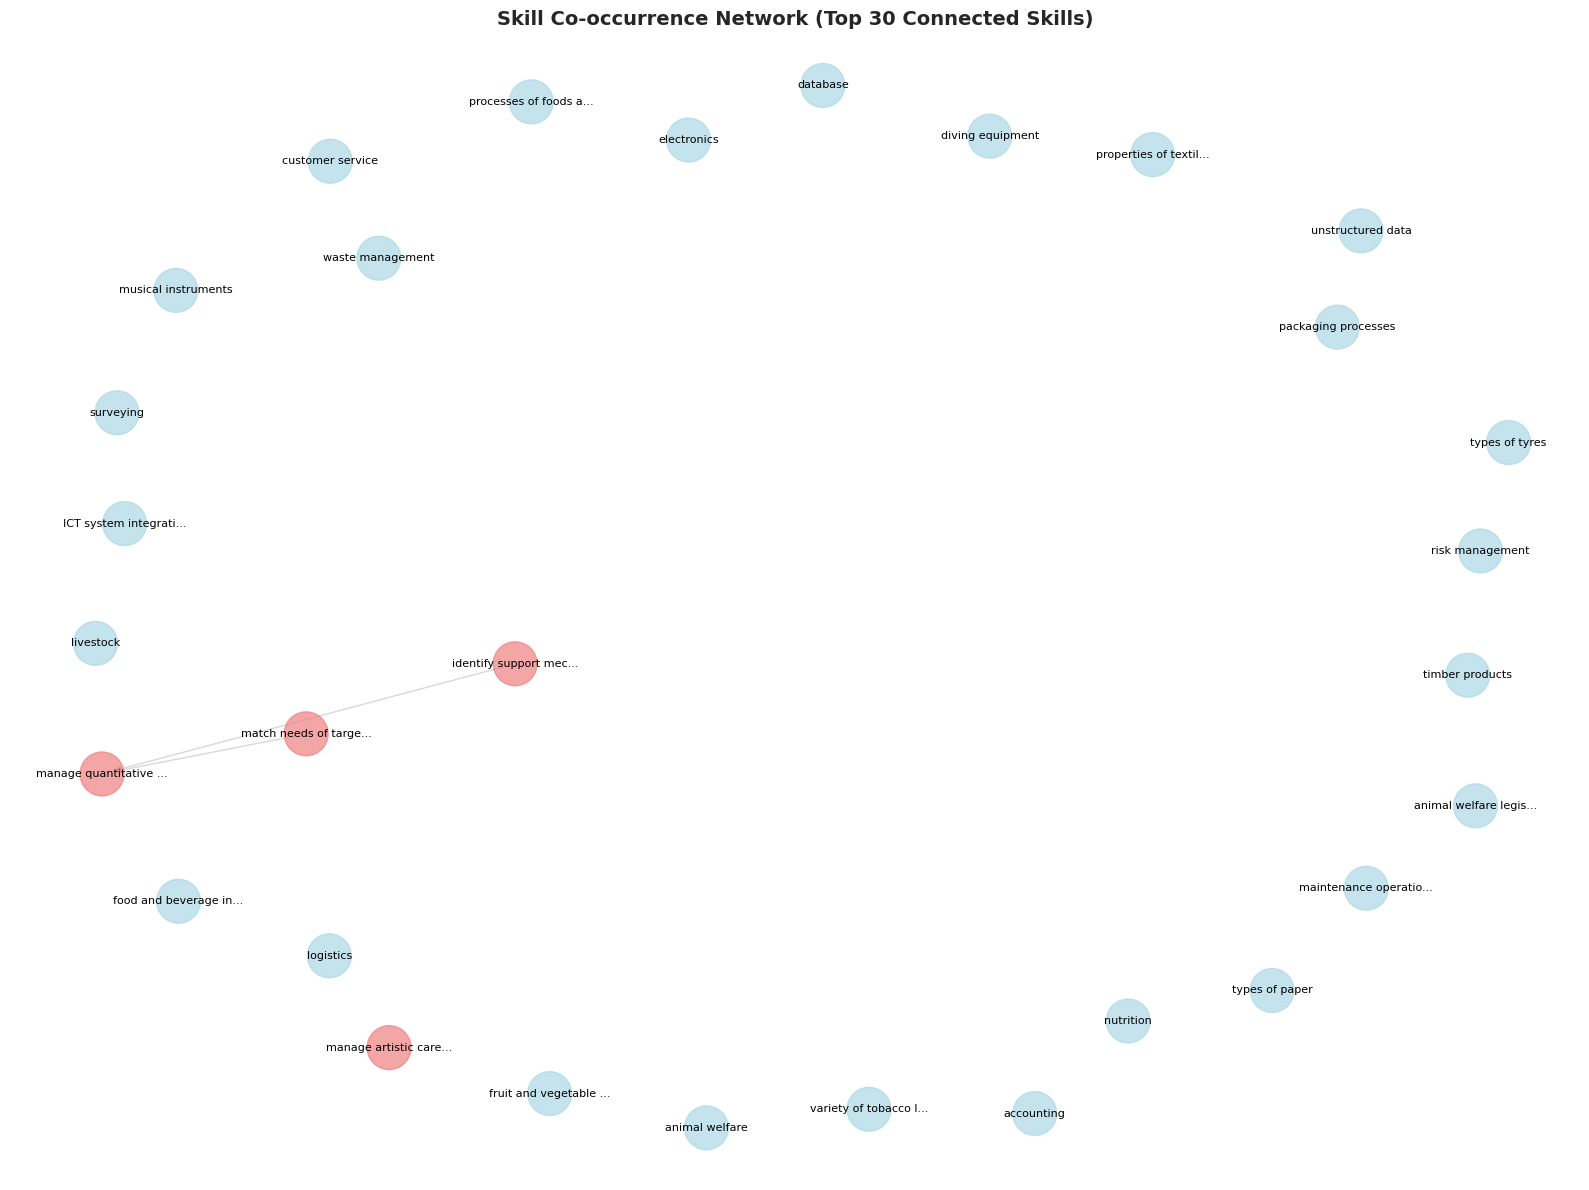


Subgraph statistics:
   • Nodes: 30
   • Edges: 2
   • Density: 0.0023


In [ ]:
# Visualize a subset of the graph (top connected skills)
print("\nVisualizing skill co-occurrence network (top 30 most connected skills)...")

# Get top 30 most connected nodes
top_30_nodes = [node for node, degree in sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:30]]

# Create subgraph
subgraph = G.subgraph(top_30_nodes)

# Create visualization
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

# Draw nodes
node_colors = []
for node in subgraph.nodes():
    skill_info = skills[skills['conceptUri'] == node]
    if not skill_info.empty and skill_info.iloc[0].get('skillType') == 'knowledge':
        node_colors.append('lightblue')
    else:
        node_colors.append('lightcoral')

nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, 
                       node_size=1000, alpha=0.7)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', 
                       alpha=0.3, arrows=True, arrowsize=10)

# Draw labels (abbreviated)
labels = {}
for node in subgraph.nodes():
    skill_info = skills[skills['conceptUri'] == node]
    if not skill_info.empty:
        full_name = skill_info.iloc[0]['preferredLabel']
        # Abbreviate long names
        labels[node] = full_name[:20] + '...' if len(full_name) > 20 else full_name

nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)

plt.title('Skill Co-occurrence Network (Top 30 Connected Skills)', 
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Network statistics
print(f"\nSubgraph statistics:")
print(f"   • Nodes: {subgraph.number_of_nodes()}")
print(f"   • Edges: {subgraph.number_of_edges()}")
print(f"   • Density: {nx.density(subgraph):.4f}")


## 7. Summary and Next Steps


In [ ]:
print("SUMMARY OF KEY FINDINGS")
print("=" * 80)

summary = f"""
KEY INSIGHTS FROM ESCO TAXONOMY ANALYSIS:

1. DATASET OVERVIEW
   - {total_skills:,} unique skills in the taxonomy
   - {total_occupations:,} distinct occupations
   - {total_relations:,} occupation-skill relationships
   - Average of {avg_skills_per_occ:.1f} skills per occupation

2. SKILL HIERARCHY
   - Multi-level taxonomy with clearly defined pillars
   - {len(skill_groups)} skill groups organizing the taxonomy
   - Hierarchical structure enables skill categorization and navigation

3. SKILL DISTRIBUTION
   - Most frequent skills appear in 10%+ of all occupations
   - Clear distinction between knowledge and competence/skill types
   - Strong clustering around certain skill domains

4. NETWORK STRUCTURE
   - Skill-skill relations show {G.number_of_nodes()} interconnected skills
   - Average of {sum(dict(G.degree()).values()) / G.number_of_nodes():.1f} connections per skill
   - Network reveals skill dependencies and relationships

5. NEXT STEPS FOR ANALYSIS
   - Deep dive into specific skill pillars or occupational families
   - Temporal analysis of skill evolution (if modification dates available)
   - Skill gap analysis between related occupations
   - Predictive modeling for skill demand forecasting
   - Text mining of skill descriptions for semantic relationships
"""

print(summary)


SUMMARY OF KEY FINDINGS

KEY INSIGHTS FROM ESCO TAXONOMY ANALYSIS:

1. DATASET OVERVIEW
   - 13,939 unique skills in the taxonomy
   - 3,039 distinct occupations
   - 129,004 occupation-skill relationships
   - Average of 42.4 skills per occupation

2. SKILL HIERARCHY
   - Multi-level taxonomy with clearly defined pillars
   - 640 skill groups organizing the taxonomy
   - Hierarchical structure enables skill categorization and navigation

3. SKILL DISTRIBUTION
   - Most frequent skills appear in 10%+ of all occupations
   - Clear distinction between knowledge and competence/skill types
   - Strong clustering around certain skill domains

4. NETWORK STRUCTURE
   - Skill-skill relations show 5650 interconnected skills
   - Average of 2.1 connections per skill
   - Network reveals skill dependencies and relationships

5. NEXT STEPS FOR ANALYSIS
   - Deep dive into specific skill pillars or occupational families
   - Temporal analysis of skill evolution (if modification dates available)
  